In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [2]:
#Load your dataset
df = pd.read_csv("../../0_DataPreparation/initialdata/transformed_data.csv")

#Ensure the 'Datum' column is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

#Define time ranges
train_start = '2013-07-01'
train_end = '2017-07-31'
val_start = '2017-08-01'
val_end = '2018-07-31'
test_start = '2018-08-01'
test_end = '2019-07-30'

#Split data
train_data = df[(df['Datum'] >= train_start) & (df['Datum'] <= train_end)]
validation_data = df[(df['Datum'] >= val_start) & (df['Datum'] <= val_end)]
test_data = df[(df['Datum'] >= test_start) & (df['Datum'] <= test_end)]

#Optional: print shapes
print("Train shape:", train_data.shape)
print("Validation shape:", validation_data.shape)
print("Test shape:", test_data.shape)

Train shape: (7517, 13)
Validation shape: (1839, 13)
Test shape: (351, 13)


In [3]:
Y = train_data['Umsatz']
X = sm.add_constant(
	pd.get_dummies(train_data['Warengruppe'], drop_first=True, dtype=int)
	.join(pd.get_dummies(train_data['Weekday'], drop_first=True, dtype=int))
    .join(train_data['Temperatur'])
    .join(train_data['Windgeschwindigkeit'])
)

# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]

# change indices so that they start from 0
Y_clean.index = range(len(Y_clean))
X_clean.index = range(len(X_clean))

# Fit the model
model = sm.OLS(Y_clean, X_clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     1434.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:03:34   Log-Likelihood:                -43341.
No. Observations:                7487   AIC:                         8.671e+04
Df Residuals:                    7473   BIC:                         8.681e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  58.6458    

In [4]:
predicted = results.predict(X_clean)
actual = Y_clean
residuals = actual - predicted

comparison_df = pd.DataFrame({
    'Predicted': predicted,
    'Actual': actual,
    'Residuals': residuals
})

print("Table (Head) to compare predicted and actual values:\n", comparison_df.head())

Table (Head) to compare predicted and actual values:
     Predicted  Actual   Residuals
0  131.899883  148.83   16.930117
1  421.063894  535.86  114.796106
2  174.656194  201.20   26.543806
3   98.811799   65.89  -32.921799
4  291.423305  317.48   26.056695


Second dataset with holidays

In [5]:
#Load your dataset
df2 = pd.read_csv("../../0_DataPreparation/initialdata/merged_data_temperature+holidays+weather_impressions.csv") # 

#Ensure the 'Datum' column is in datetime format
df2['Datum'] = pd.to_datetime(df2['Datum'])

#Split data
train_data2 = df2[(df2['Datum'] >= train_start) & (df2['Datum'] <= train_end)]
validation_data2 = df2[(df2['Datum'] >= val_start) & (df2['Datum'] <= val_end)]
test_data2 = df2[(df2['Datum'] >= test_start) & (df2['Datum'] <= test_end)]

Third dataset with Kiwo

In [6]:
df3 = pd.read_csv("../../0_DataPreparation/initialdata/kiwo.csv")
df3['Datum'] = pd.to_datetime(df3['Datum'])
train_data3 = df3[(df3['Datum'] >= train_start) & (df3['Datum'] <= train_end)]
validation_data3 = df3[(df3['Datum'] >= val_start) & (df3['Datum'] <= val_end)]
test_data3 = df3[(df3['Datum'] >= test_start) & (df3['Datum'] <= test_end)]

In [7]:
Y = train_data['Umsatz']
X = sm.add_constant(
	pd.get_dummies(train_data['Warengruppe'], drop_first=True, dtype=int)
	.join(pd.get_dummies(train_data['Weekday'], drop_first=True, dtype=int))
    .join(train_data['Temperatur'])
    .join(train_data['Windgeschwindigkeit'])
    .join(train_data2['Is_Holiday'])
    .join(pd.get_dummies(train_data3['KielerWoche'], drop_first=True, dtype=int))
)

# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]

# change indices so that they start from 0
Y_clean.index = range(len(Y_clean))
X_clean.index = range(len(X_clean))

# Fit the model
model = sm.OLS(Y_clean, X_clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1346.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:03:34   Log-Likelihood:                -43313.
No. Observations:                7487   AIC:                         8.666e+04
Df Residuals:                    7472   BIC:                         8.676e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  58.9763    

In [8]:
# Load the test data
test_data = pd.read_csv("../Linear_regression_Lukas/test.csv")

# Ensure the 'Datum' column is in datetime format and extract the weekday
test_data['Datum'] = pd.to_datetime(test_data['Datum'])
test_data['Weekday'] = test_data['Datum'].dt.day_name()

# Replace Warengruppe numbers with product names (same as in training data)
warengruppe_mapping = {
    1: 'Brot',
    2: 'Brötchen', 
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}
test_data['Warengruppe'] = test_data['Warengruppe'].map(warengruppe_mapping)

# Create dummy variables for the test data
X_test = pd.get_dummies(test_data[['Warengruppe', 'Weekday']], drop_first=True, dtype=int)
X_test = sm.add_constant(X_test)  # Für das Interzept

# Ensure that the test data has the same columns as the training data
for col in X_clean.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Ensure the order of columns matches the training data
X_test = X_test[X_clean.columns]

# predict with the model
preds = results.predict(X_test)

# create submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'Umsatz': preds
})

submission.to_csv("sub1.csv", index=False)
print("Submission file created")

Submission file created


Plot

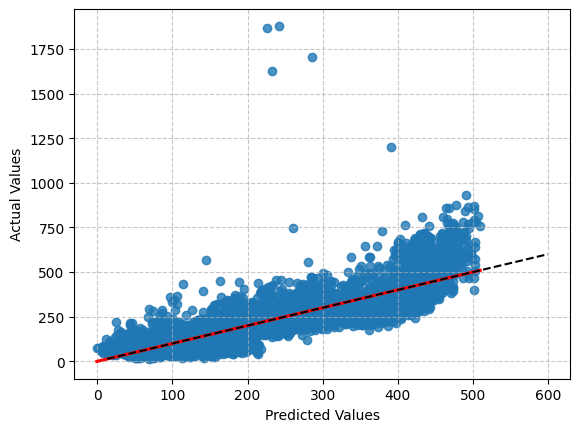

In [9]:
# Plotting the predicted vs actual values
sns.regplot(x=predicted, y=actual, line_kws={"color": "red"})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(alpha=0.7, linestyle='--')
# adding the perfect y=x line
min = actual.min()
max = 600
plt.plot([min, max], [min, max], color='black', linestyle='--')